# Cours 2

Les reseaux neuronales can take into consideration lagging and other harder properties.

In [104]:
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import yfinance as yf
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
import gc
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


# only grow GPU memory when needed
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)


from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

In [105]:
df = pd.read_csv('ES_options_prices.csv.gz')
df.head(1)

,index,bid,ask,strike,option_type,expiry,days_to_expiry
0,2009-03-09 15:00:00,0.05,0.25,1000,call,2009-04-17,39


### This will move the time till midnight to the first column

In [106]:
df['index'] = pd.to_datetime(df['index']).dt.normalize() # convert to datetime and remove time
df = df.rename(columns={'index': 'Date'}) # change name of the index column
df.head(1)

,Date,bid,ask,strike,option_type,expiry,days_to_expiry
0,2009-03-09,0.05,0.25,1000,call,2009-04-17,39


### Add mid_option column

In [107]:
df['mid_option'] = (df['ask'] + df['bid']) / 2
df.head(2)

,Date,bid,ask,strike,option_type,expiry,days_to_expiry,mid_option
0,2009-03-09,0.05,0.25,1000,call,2009-04-17,39,0.15
1,2009-03-09,0.15,1.55,1000,call,2009-05-15,67,0.85


In [108]:
df['spread_relatif'] = (df['ask'] - df['bid']) / df['mid_option']
df.head(1)

,Date,bid,ask,strike,option_type,expiry,days_to_expiry,mid_option,spread_relatif
0,2009-03-09,0.05,0.25,1000,call,2009-04-17,39,0.15,1.333333


## Getting data from Yahoo

In [109]:
symbol = 'ES=F'
data_es = yf.Ticker(symbol).history(start="2006-01-01", end="2014-11-20")
data_es.index = data_es.index.tz_localize(None)

In [110]:
data_es.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2006-01-03,1255.25,1277.50,1251.50,1274.75,1149130,0.0,0.0
2006-01-04,1274.50,1282.25,1270.75,1280.50,902220,0.0,0.0
2006-01-05,1280.50,1283.25,1275.75,1281.25,761183,0.0,0.0
2006-01-06,1281.25,1293.00,1280.25,1291.75,899355,0.0,0.0
2006-01-09,1291.25,1297.50,1290.25,1295.00,774670,0.0,0.0


In [111]:
T = 15
data_es['intern-value-roger'] = np.log( data_es['High'] / data_es['Close'] ) * np.log( data_es['High'] / data_es['Open'] )
data_es['intern-value-roger'] += np.log(data_es['Low'] / data_es['Close']) * np.log(data_es['Low'] / data_es['Open'])
data_es['volatility'] = np.sqrt( data_es['intern-value-roger'].rolling(window=T).mean())
data_es.iloc[55:65, :]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,intern-value-roger,volatility
Date,,,,,,,,,
2006-03-21,1315.25,1321.50,1305.50,1307.50,1031144,0.0,0.0,0.000062,0.005898
2006-03-22,1307.25,1316.00,1304.75,1314.50,737198,0.0,0.0,0.000022,0.005952
2006-03-23,1314.75,1316.00,1307.00,1311.75,675368,0.0,0.0,0.000025,0.005899
2006-03-24,1311.75,1316.25,1307.50,1312.75,596147,0.0,0.0,0.000022,0.005434
2006-03-27,1313.00,1314.50,1307.75,1311.00,462838,0.0,0.0,0.000013,0.005184
2006-03-28,1310.75,1315.50,1300.25,1302.50,929472,0.0,0.0,0.000050,0.005326
2006-03-29,1302.25,1315.00,1300.75,1310.00,896642,0.0,0.0,0.000045,0.005201
2006-03-30,1310.50,1319.25,1304.75,1307.50,991068,0.0,0.0,0.000069,0.005436
2006-03-31,1307.75,1311.75,1302.75,1307.50,846848,0.0,0.0,0.000024,0.005423


<Figure size 1500x500 with 0 Axes>

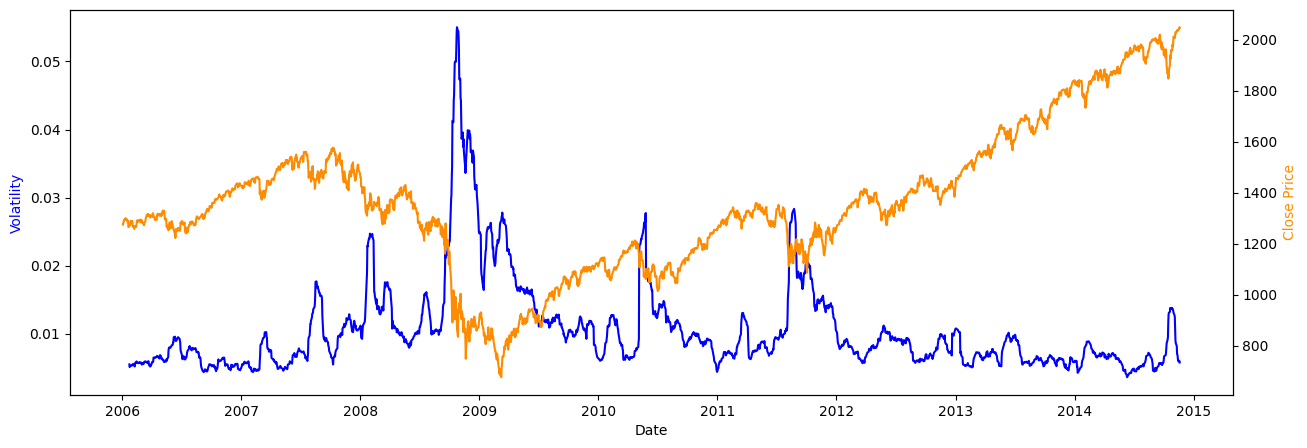

In [112]:
plt.figure(figsize=(15, 5));
dark_orange = '#FF8C00'

fig, ax1 = plt.subplots(figsize=(15, 5));

sns.lineplot(data=data_es, x='Date', y='volatility', ax=ax1, color='blue');
ax1.set_ylabel('Volatility', color='blue');
ax1.set_xlabel('Date');

ax2 = ax1.twinx()

sns.lineplot(data=data_es, x='Date', y='Close', ax=ax2, color=dark_orange);
ax2.set_ylabel('Close Price', color=dark_orange);
plt.show();


## Merge the dataframes

In [113]:
df2 = df.merge(data_es[['Close', 'volatility']], on='Date', how='left')
df2.head()

,Date,bid,ask,strike,option_type,expiry,days_to_expiry,mid_option,spread_relatif,Close,volatility
0,2009-03-09,0.05,0.25,1000,call,2009-04-17,39,0.150,1.333333,676.0,0.02665
1,2009-03-09,0.15,1.55,1000,call,2009-05-15,67,0.850,1.647059,676.0,0.02665
2,2009-03-09,0.50,2.10,1000,call,2009-06-19,102,1.300,1.230769,676.0,0.02665
3,2009-03-09,1.70,2.35,1000,call,2009-09-18,193,2.025,0.320988,676.0,0.02665
4,2009-03-09,4.00,5.50,1000,call,2009-12-18,284,4.750,0.315789,676.0,0.02665


### Rescale Price of the option and Strike

The pdf said to rescale with respect mid, which I will assume it is the price of the option that day (close price).

In [114]:
df2['strike_rescaled'] = df2['strike'] / df2['Close']
df2['mid_option_scaled'] = df2['mid_option'] / df2['Close']
df2.head(5)

,Date,bid,ask,strike,option_type,expiry,days_to_expiry,mid_option,spread_relatif,Close,volatility,strike_rescaled,mid_option_scaled
0,2009-03-09,0.05,0.25,1000,call,2009-04-17,39,0.150,1.333333,676.0,0.02665,1.47929,0.000222
1,2009-03-09,0.15,1.55,1000,call,2009-05-15,67,0.850,1.647059,676.0,0.02665,1.47929,0.001257
2,2009-03-09,0.50,2.10,1000,call,2009-06-19,102,1.300,1.230769,676.0,0.02665,1.47929,0.001923
3,2009-03-09,1.70,2.35,1000,call,2009-09-18,193,2.025,0.320988,676.0,0.02665,1.47929,0.002996
4,2009-03-09,4.00,5.50,1000,call,2009-12-18,284,4.750,0.315789,676.0,0.02665,1.47929,0.007027


### Erase nan values

In [115]:
print(df2.isnull().sum())

Date                   0
bid                    0
ask                    0
strike                 0
option_type            0
expiry                 0
days_to_expiry         0
mid_option             0
spread_relatif         0
Close                812
volatility           812
strike_rescaled      812
mid_option_scaled    812
dtype: int64


In [116]:
df2 = df2.dropna()

### Compute black-schole prices

In [117]:
from scipy.stats import norm

def black_schole_price (S0, K, T, r, sigma, option_type = "call"):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2) 
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)

In [118]:
# we have the daily volatility, we need to annualize it

bs_call = black_schole_price(
    S0 = df2['Close'], K = df2['strike'], 
    T = df2['days_to_expiry'] / 365, r = 0, sigma = df2['volatility'] * np.sqrt(252), option_type = "call"
)
bs_put = black_schole_price(
    S0 = df2['Close'], K = df2['strike'], 
    T = df2['days_to_expiry'] / 365, r = 0, sigma = df2['volatility'] * np.sqrt(252), option_type = "put"
)
bs_call.head()

0     0.077656
1     0.812169
2     2.953655
3    12.098127
4    22.993246
dtype: float64

In [119]:
df2['bs'] = np.where(df2['option_type'] == 'call', bs_call, bs_put)
df2.head(10)

,Date,bid,ask,strike,option_type,expiry,days_to_expiry,mid_option,spread_relatif,Close,volatility,strike_rescaled,mid_option_scaled,bs
0,2009-03-09,0.05,0.25,1000,call,2009-04-17,39,0.150,1.333333,676.0,0.02665,1.479290,0.000222,0.077656
1,2009-03-09,0.15,1.55,1000,call,2009-05-15,67,0.850,1.647059,676.0,0.02665,1.479290,0.001257,0.812169
2,2009-03-09,0.50,2.10,1000,call,2009-06-19,102,1.300,1.230769,676.0,0.02665,1.479290,0.001923,2.953655
3,2009-03-09,1.70,2.35,1000,call,2009-09-18,193,2.025,0.320988,676.0,0.02665,1.479290,0.002996,12.098127
4,2009-03-09,4.00,5.50,1000,call,2009-12-18,284,4.750,0.315789,676.0,0.02665,1.479290,0.007027,22.993246
5,2009-03-09,314.00,350.00,1000,put,2009-03-20,11,332.000,0.108434,676.0,0.02665,1.479290,0.491124,324.000001
6,2009-03-09,324.50,331.00,1000,put,2009-04-17,39,327.750,0.019832,676.0,0.02665,1.479290,0.484837,324.077656
7,2009-03-09,328.00,334.50,1000,put,2009-09-18,193,331.250,0.019623,676.0,0.02665,1.479290,0.490015,336.098127
8,2009-03-09,332.00,338.50,1000,put,2009-12-18,284,335.250,0.019389,676.0,0.02665,1.479290,0.495932,346.993246
9,2009-03-09,329.50,336.00,1005,put,2009-06-19,102,332.750,0.019534,676.0,0.02665,1.486686,0.492234,331.801259


Text(0.5, 1.0, 'Black-Scholes vs mid price for put options')

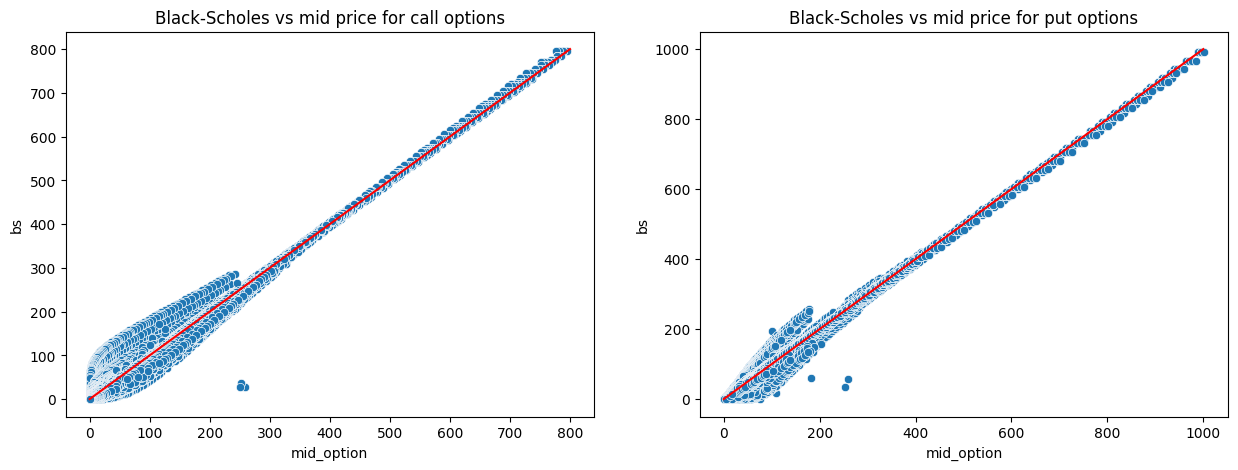

In [120]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df2[df2['option_type'] == 'call'], x='mid_option', y='bs')
sns.lineplot(x=[0, 800], y=[0, 800], color='red')
plt.title('Black-Scholes vs mid price for call options')
plt.subplot(1,2,2)
sns.scatterplot(data=df2[df2['option_type'] == 'put'], x='mid_option', y='bs')
sns.lineplot(x=[0, 1000], y=[0, 1000], color='red')
plt.title('Black-Scholes vs mid price for put options')

In [121]:
sus = df2[  (df2['option_type'] == 'call') & 
          ((300 > df2['mid_option']) & (df2['mid_option'] > 200)) & 
          ((100> df2['bs']) & (df2['bs'] > 0)) ]

In [122]:
sus.head()

,Date,bid,ask,strike,option_type,expiry,days_to_expiry,mid_option,spread_relatif,Close,volatility,strike_rescaled,mid_option_scaled,bs
102458,2013-10-28,16.5,500.0,1740,call,2013-11-15,18,258.25,1.872217,1759.0,0.006383,0.989198,0.146816,26.998570
103826,2013-11-11,2.5,500.0,1730,call,2013-11-15,4,251.25,1.980100,1767.5,0.006110,0.978784,0.142150,37.611088
103837,2013-11-11,2.1,500.0,1740,call,2013-11-15,4,251.05,1.983270,1767.5,0.006110,0.984441,0.142037,27.971281


We can appreciate that the outliers are given to the fact that the products are near maturity and the price of the stock is over the strike price.

# Parameters incomplete

For this section, I'm going to restrain my code to work only with call options, since the put and call options will have a different price. We could use all the data i we provide the neural network a parameter stating that the values corresponds either a call or a put option. For simplicity, we are just going to use the call option.

We are saying that we are working with incomplete parameters, because at least, the black-scholes formula, which is the one most naive but also a first easy approach to the price of the call or puts, needs as input the risk-free rate, the volatility, the strike price, the price of the stock, and the time to maturity. We have the strike price, the maturity and the spread. The price of the stock is given implicitely when we normalized the strike price by the price of the stock. Then we are missing the **volatility**.

## Call

In [123]:
np.random.seed(44)
tf.random.set_seed(44)

X = df2[['strike_rescaled', 'days_to_expiry', 'spread_relatif']][df2['option_type'] == 'call']
y = df2['mid_option'][df2['option_type'] == 'call']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

It is important to set ```use_bias``` to False, since the model tends to converge to a constant value.

We can see that the maximum value of the training dataset is 795, so the output should be higher than this value and also, the output of the model shouldn't be negative (wouldnt make sense that the option has a negative value).

In [124]:
print("max value of options", np.max(y))
print("Min value of the options", np.min(y))

max value of options 795.0
Min value of the options 0.07500000000000001


In [125]:
def create_first_model(use_bias = True):
    model_call = Sequential()
    model_call.add(Input(shape=(3,)))
    model_call.add(Dense(32, activation='relu', use_bias=use_bias))
    model_call.add(Dense(64, activation='relu', use_bias=use_bias))
    model_call.add(Dense(128, activation='relu', use_bias=use_bias))
    model_call.add(Dense(64, activation='relu', use_bias=use_bias))
    model_call.add(Dense(32, activation='relu', use_bias=use_bias))
    model_call.add(Dense(16, activation='relu', use_bias=use_bias))
    model_call.add(Dense(8, activation='relu', use_bias=use_bias))
    model_call.add(Dense(1, activation='sigmoid', use_bias=use_bias))
    model_call.add(Lambda(lambda x: x * 800))
    model_call.compile(optimizer=Adam(learning_rate = 1e-3), loss=MeanSquaredError())
    return model_call

In [126]:
model_call = create_first_model(use_bias=False)
history = model_call.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[es, lr_scheduler])

Epoch 1/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12832.1768 - val_loss: 11741.3555 - learning_rate: 0.0010
Epoch 2/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10954.4746 - val_loss: 12682.7041 - learning_rate: 0.0010
Epoch 3/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9183.8438 - val_loss: 6282.0103 - learning_rate: 0.0010
Epoch 4/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6045.0488 - val_loss: 4448.9160 - learning_rate: 0.0010
Epoch 5/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5279.9834 - val_loss: 4926.0752 - learning_rate: 0.0010
Epoch 6/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5158.3804 - val_loss: 4298.4712 - learning_rate: 0.0010
Epoch 7/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4851.5508 - val_loss: 4208.4775 - learning_rate: 0.0010
Epoch 8/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4721.3208 - val_loss: 4166.2788 - learning_rate: 0.0010
Epoch 9/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss:

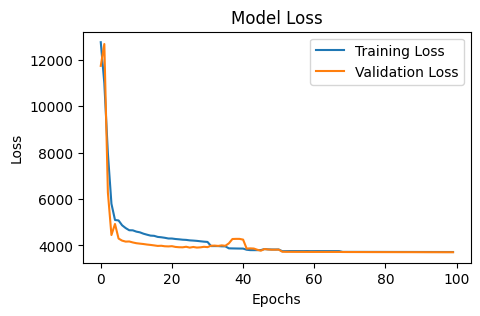

In [127]:
# Plot the training and validation loss
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [128]:
y_pred_call = model_call.predict(X_test).flatten()
print('MSE:', MeanSquaredError()(y_test, y_pred_call).numpy())
print('MAE:', MeanAbsoluteError()(y_test, y_pred_call).numpy())

659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step
MSE: 3643.6982
MAE: 37.97936


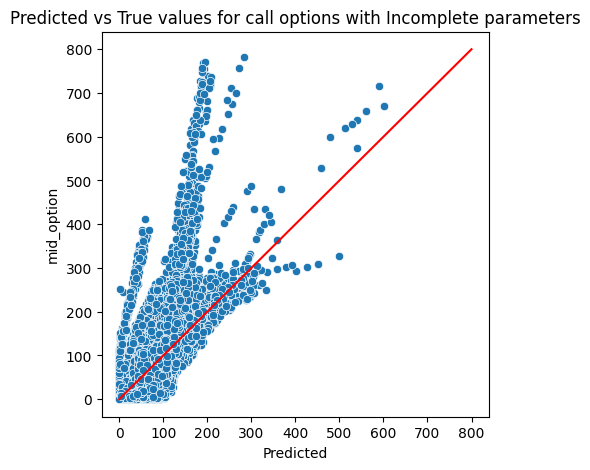

In [129]:
def show_graph(y_pred_call, y_test, opt_type = "call", title=""):    
    plt.figure(figsize=(5, 5))
    sns.scatterplot(x = y_pred_call, y = y_test)
    sns.lineplot(x=np.linspace(0, 800, 100), y=np.linspace(0, 800, 100), color='red') #horizontal line
    plt.xlabel('Predicted')
    plt.title(f"Predicted vs True values for {opt_type} options with {title}")
    
show_graph(y_pred_call, y_test, opt_type = "call", title="Incomplete parameters")

From the graph, we see that the model tends to be more conservative at the moment of predicting the price of the option. There is a tendence to provide a lower price than the one expected. This might be due the fact that the model, without the volatility, cannot estimate how much the price of the option will change in the future. As we know, if there is a higher volatility, the price of the option will be higher since there is a higher chance that in the future the price of the stock will be higher than the strike price.

### Measure

- MSE: Mean Squared Error
- MAE: Mean Absolute Error
- RMSE: Root Mean Squared Error
- MAPE: Mean Absolute Percentage Error
- Max Error: Maximum Error
- $R^2$: Coefficient of Determination. Measures the proportion of variance explained by the model (1 is perfect, 0 is the mean of the target, negative is worse than the mean)

In [130]:
rounding_digit = 5

def MSE(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def R2 (y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def max_error(y_true, y_pred):
    return np.max(np.abs(y_true - y_pred))

def show_metrics(y_true, y_pred):
    print('MSE:', round(MSE(y_true, y_pred), rounding_digit))
    print('MAE:', round(MAE(y_true, y_pred), rounding_digit))
    print('RMSE:', round(RMSE(y_true, y_pred), rounding_digit))
    print('MAPE:', round(MAPE(y_true, y_pred), rounding_digit), '%')
    print('R2:', round(R2(y_true, y_pred), rounding_digit))
    print('Max Error:', round(max_error(y_true, y_pred), 4))

In [131]:
show_metrics(y_test, y_pred_call) 

MSE: 3643.69811
MAE: 37.97936
RMSE: 60.36305
MAPE: 317.00312 %
R2: 0.53133
Max Error: 577.215


We can see that our model is doing better than giving the average of the target, however the error still big to despise it.

### Predictions inside spread

In [132]:
def percentage_within_spread (y_pred, y_true, df):
    within_spread = (y_pred >= df.loc[y_true.index]['bid']) & \
    (y_pred <= df.loc[y_true.index]['ask'])
    
    count_within_spread = within_spread.sum()
    percentage_within_spread = count_within_spread / len(y_true) * 100
    print(f'Percentage of predictions within the spread: {percentage_within_spread:.2f}%')
    return percentage_within_spread

value = percentage_within_spread(y_pred_call, y_test, df2)

Percentage of predictions within the spread: 2.20%


As we can see, the predictions weren't good at all, with most of the predictions being outside the spread.

# Incomplete parameters + relative spread + volatility measure

### Call

In [133]:
import numpy as np
import tensorflow as tf
np.random.seed(44)
tf.random.set_seed(44)

X = df2[['strike_rescaled', 'days_to_expiry', 'spread_relatif', 'volatility']][df2['option_type'] == 'call']
y = df2['mid_option'][df2['option_type'] == 'call']

X = X.dropna()
y = y[X.index]

In [134]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [135]:
def create_model_volatility (use_bias = True):
    model_vol = Sequential()
    model_vol.add(Input(shape=(4,)))
    model_vol.add(Dense(32, activation='relu', use_bias=use_bias))
    model_vol.add(Dense(64, activation='relu', use_bias=use_bias))
    model_vol.add(Dense(128, activation='relu', use_bias=use_bias))
    model_vol.add(Dense(64, activation='relu', use_bias=use_bias))
    model_vol.add(Dense(32, activation='relu', use_bias=use_bias))
    model_vol.add(Dense(16, activation='relu', use_bias=use_bias))
    model_vol.add(Dense(8, activation='relu', use_bias=use_bias))
    model_vol.add(Dense(1, activation='sigmoid', use_bias=use_bias))
    model_vol.add(Lambda(lambda x: x * 800))
    model_vol.compile(optimizer=Adam(learning_rate = 1e-3), loss=MeanSquaredError())
    return model_vol

In [136]:
model_vol = create_model_volatility(use_bias=False)
history_vol = model_vol.fit(X_train, y_train, 
                            validation_data=(X_val, y_val), 
                            epochs=100, 
                            callbacks=[es, lr_scheduler])

Epoch 1/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12955.5449 - val_loss: 12031.0898 - learning_rate: 0.0010
Epoch 2/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11703.9697 - val_loss: 8629.0000 - learning_rate: 0.0010
Epoch 3/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11292.3672 - val_loss: 10672.3789 - learning_rate: 0.0010
Epoch 4/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10840.8643 - val_loss: 13259.2529 - learning_rate: 0.0010
Epoch 5/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13137.6934 - val_loss: 11742.0088 - learning_rate: 0.0010
Epoch 6/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11221.9150 - val_loss: 5493.2573 - learning_rate: 0.0010
Epoch 7/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5180.4365 - val_loss: 4416.7773 - learning_rate: 0.0010
Epoch 8/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4960.9907 - val_loss: 4310.4517 - learning_rate: 0.0010
Epoch 9/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

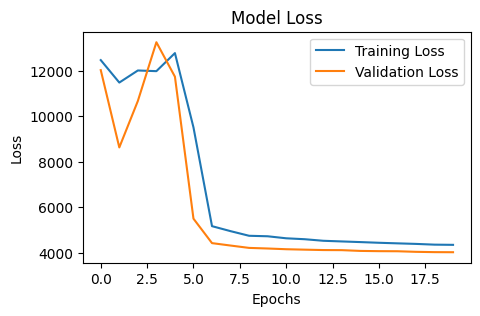

In [137]:
plt.figure(figsize=(5, 3))
plt.plot(history_vol.history['loss'], label='Training Loss')
plt.plot(history_vol.history['val_loss'], label='Validation Loss')
plt.title('Model Volatility Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [138]:
y_pred_vol = model_vol.predict(X_test).flatten()
show_metrics(y_test, y_pred_vol)

659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MSE: 3935.51638
MAE: 41.96667
RMSE: 62.73369
MAPE: 417.58363 %
R2: 0.4938
Max Error: 575.3692


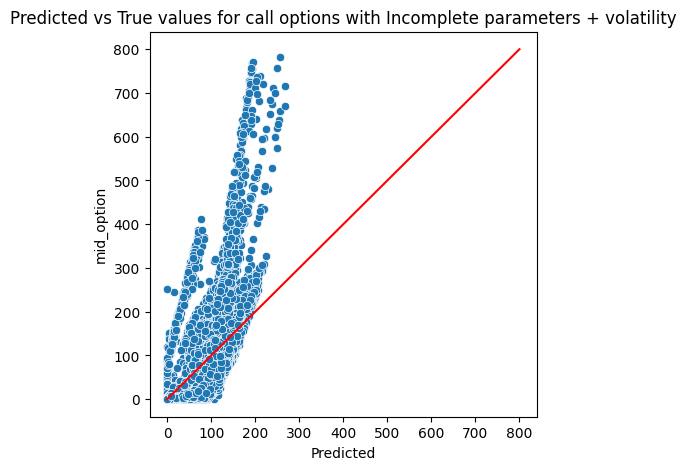

In [139]:
show_graph(y_pred_vol, y_test, opt_type = "call", title="Incomplete parameters + volatility")

The predictions in the spread are:

In [140]:
value = percentage_within_spread(y_pred_vol, y_test, df2)

Percentage of predictions within the spread: 2.25%


The model didn't improve even though we provided the empirique volatility. This might be due to three reasons:
- The model is not being able to model the black-scholes equation from the data. For example, when we implemented the blackscholes formula, we had to scale the maturity and the volatility to be in the same time span.
- The second option is that the model needs to be supplied with the explicit value of the asset and its corresponding strike value.
- The data is too noisy and the model is not able to converge. We are calculating the 

### Compare the learning speed with respect questions 2.

Training the model multiple times to see the average learning speed.

In [142]:
def mean_std (data):
    return np.mean(data), np.std(data)

Run 1
Run 2
Run 3
Run 4
Run 5
Model First: Average training time: 23.53 seconds, Standard deviation: 0.57 seconds
Model Volatility: Average training time: 24.72 seconds, Standard deviation: 1.10 seconds
Model First: Average validation loss: 6012.7023, Standard deviation: 3651.6170
Model Volatility: Average validation loss: 9586.9715, Standard deviation: 4566.3919


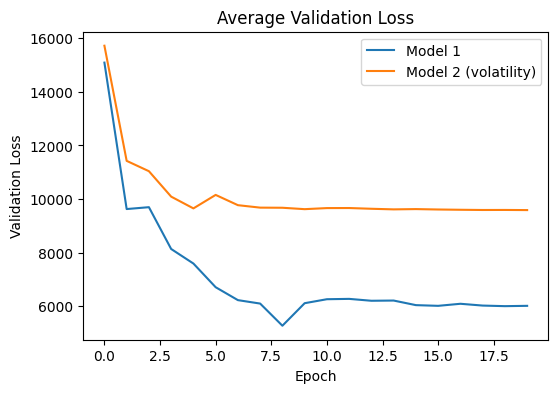

In [ ]:
#setting the seed
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

epochs = 20
n_samples = 10


X_first = df2[['strike_rescaled', 'days_to_expiry', 'spread_relatif']][df2['option_type'] == 'call']
y_first = df2['mid_option'][df2['option_type'] == 'call']
X_first = X_first.dropna()
y_first = y_first[X_first.index]

X_first_train, X_first_temp, y_first_train, y_first_temp = train_test_split(X_first, y_first, test_size=0.7, random_state=42)
X_first_val, X_first_test, y_first_val, y_first_test = train_test_split(X_first_temp, y_first_temp, test_size=0.5, random_state=42)

X_vol = df2[['strike_rescaled', 'days_to_expiry', 'spread_relatif', 'volatility']][df2['option_type'] == 'call']
y_vol = df2['mid_option'][df2['option_type'] == 'call']
X_vol = X_vol.dropna()
y_vol = y_vol[X_vol.index]

X_vol_train, X_vol_temp, y_vol_train, y_vol_temp = train_test_split(X_vol, y_vol, test_size=0.7, random_state=42)
X_vol_val, X_vol_test, y_vol_val, y_vol_test = train_test_split(X_vol_temp, y_vol_temp, test_size=0.5, random_state=42)

last_val_loss_model_first = []
last_val_loss_model_vol = []

val_losses_model_first = []
val_losses_model_vol = []

training_times_model_first = []
training_times_model_vol = []

for i in range(n_samples):
    print(f"Run {i+1}")
    
    # Model First
    start_time = time.time()
    model_first_speed = create_first_model(use_bias=False)
    history_first_speed = model_first_speed.fit(X_first_train, y_first_train, 
                                            validation_data=(X_first_val, y_first_val), 
                                            epochs=epochs, verbose=0)
    end_time = time.time()
    training_times_model_first.append(end_time - start_time)
    last_val_loss_model_first.append(history_first_speed.history['val_loss'][-1])
    val_losses_model_first.append(history_first_speed.history['val_loss'])
    
    # Model Volatility
    start_time = time.time()
    model_vol_speed = create_model_volatility(use_bias=False)
    history_vol_speed = model_vol_speed.fit(X_vol_train, y_vol_train, 
                                            validation_data=(X_vol_val, y_vol_val), 
                                            epochs=epochs, verbose=0)
    end_time = time.time()
    training_times_model_vol.append(end_time - start_time)
    last_val_loss_model_vol.append(history_vol_speed.history['val_loss'][-1])
    val_losses_model_vol.append(history_vol_speed.history['val_loss'])

mean_time_model_first, std_time_model_first = mean_std(training_times_model_first)
mean_time_model_vol, std_time_model_vol = mean_std(training_times_model_vol)

print(f"Model First: Average training time: {mean_time_model_first:.2f} seconds, Standard deviation: {std_time_model_first:.2f} seconds")
print(f"Model Volatility: Average training time: {mean_time_model_vol:.2f} seconds, Standard deviation: {std_time_model_vol:.2f} seconds")


mean_val_loss_model_first, std_val_loss_model_first = mean_std(last_val_loss_model_first)
mean_val_loss_model_vol, std_val_loss_model_vol = mean_std(last_val_loss_model_vol)

print(f"Model First: Average validation loss: {mean_val_loss_model_first:.4f}, Standard deviation: {std_val_loss_model_first:.4f}")
print(f"Model Volatility: Average validation loss: {mean_val_loss_model_vol:.4f}, Standard deviation: {std_val_loss_model_vol:.4f}")

avg_val_loss_model_first = np.mean(val_losses_model_first, axis=0)
avg_val_loss_model_vol = np.mean(val_losses_model_vol, axis=0)

plt.figure(figsize=(6, 4))
plt.title('Average Validation Loss')
plt.plot(avg_val_loss_model_first, label='Model 1')
plt.plot(avg_val_loss_model_vol, label='Model 2 (volatility)')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()


We can see that using the volatility, it takes longer and is harder to converge. This is because the volatility is a more complex measure and the model takes longer to understand the data. Also, from the result from the validation loss, we can see that the model is not being able to capture the information that the volatility can provide to the model. In fact, the model worsened the predictions, probably due to the fact that the volatility at this point might look like noise to the model.

# Parameters incomplete + spread relative + volatility + black scholes

In [203]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

X = df2[['strike_rescaled', 'days_to_expiry', 'spread_relatif', 'volatility', 'bs']][df2['option_type'] == 'call']
y = df2['mid_option'][df2['option_type'] == 'call']

X = X.dropna()
y = y[X.index]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

In [204]:
def create_model_bs (use_bias = True):
    model = Sequential()
    model.add(Input(shape=(5,)))
    model.add(Dense(32, activation='relu', use_bias=use_bias))
    model.add(Dense(64, activation='relu', use_bias=use_bias))
    model.add(Dense(128, activation='relu', use_bias=use_bias))
    model.add(Dense(64, activation='relu', use_bias=use_bias))
    model.add(Dense(32, activation='relu', use_bias=use_bias))
    model.add(Dense(16, activation='relu', use_bias=use_bias))
    model.add(Dense(8, activation='relu', use_bias=use_bias))
    model.add(Dense(1, activation='sigmoid', use_bias=use_bias))
    model.add(Lambda(lambda x: x * 800))
    model.compile(optimizer=Adam(learning_rate = 1e-3), loss=MeanSquaredError())    
    return model

Epoch 1/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 40173.2148 - val_loss: 11195.8389 - learning_rate: 0.0010
Epoch 2/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 11567.1016 - val_loss: 11010.2500 - learning_rate: 0.0010
Epoch 3/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 11110.0947 - val_loss: 9927.3613 - learning_rate: 0.0010
Epoch 4/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9969.1270 - val_loss: 4461.4683 - learning_rate: 0.0010
Epoch 5/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2287.5840 - val_loss: 1148.2642 - learning_rate: 0.0010
Epoch 6/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 514.5579 - val_loss: 150.8792 - learning_rate: 0.0010
Epoch 7/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 230.5256 - val_loss: 473.2155 - learning_rate: 0.0010
Epoch 8/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 529.2509 - val_loss: 126.8472 - learning_rate: 0.0010
Epoch 9/100
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 346.

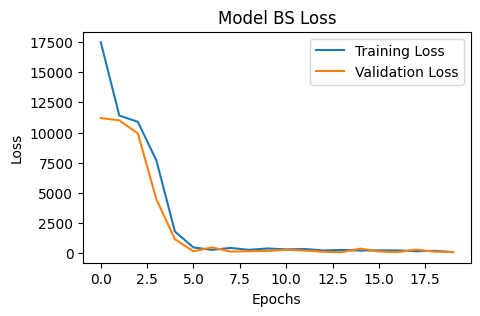

In [205]:
model_bs = create_model_bs(use_bias=False)
history_bs = model_bs.fit(X_train, y_train, 
                            validation_data=(X_val, y_val), 
                            epochs=100, 
                            callbacks=[es, lr_scheduler])

plt.figure(figsize=(5, 3))
plt.plot(history_bs.history['loss'], label='Training Loss')
plt.plot(history_bs.history['val_loss'], label='Validation Loss')
plt.title('Model BS Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [206]:
y_pred_bs = model_bs.predict(X_test).flatten()
show_metrics(y_test, y_pred_bs)

659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MSE: 78.43073
MAE: 5.4132
RMSE: 8.85611
MAPE: 31.27208 %
R2: 0.98991
Max Error: 232.4095


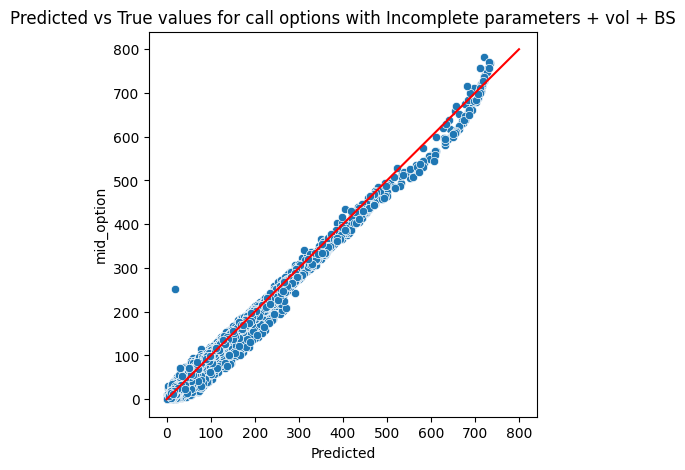

In [207]:
show_graph(y_pred_bs, y_test, opt_type = "call", title="Incomplete parameters + vol + BS")

In [208]:
value = percentage_within_spread(y_pred_bs, y_test, df2)

Percentage of predictions within the spread: 15.11%


We can clearly see an improvement in the model. We can see from the beginning of this script, that the black-scholes model gives a relative good prediction for the price of the option. Therefore, the model now is getting most of its accuracy thanks to this new parameter.

Yet, attaining around 15% of the predictions inside the spread isn't good enough. 

### Compare the learning speed with respect questions 2 and 1.

Run 1
Run 2
Model diverged
Run 3
Run 4
Model diverged
Run 5
Model diverged
Run 6
Model diverged
Run 7
Model diverged
Run 8
Model diverged
Run 9
Run 10
Model BS: Average training time: 26.48 seconds, Standard deviation: 2.21 seconds
Model BS: Average validation loss: 114.1723, Standard deviation: 45.8815


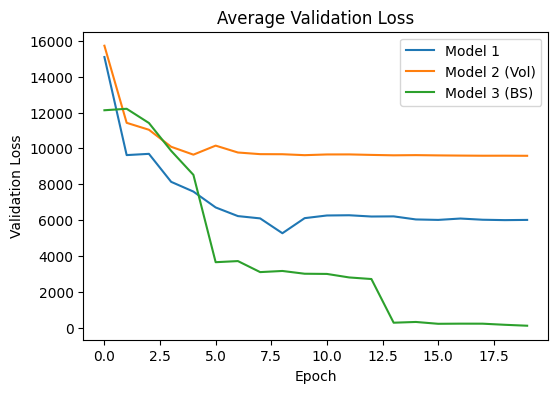

In [202]:
#setting the seed
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

epochs = 20
n_samples = 10

X_bs = df2[['strike_rescaled', 'days_to_expiry', 'spread_relatif', 'volatility', 'bs']][df2['option_type'] == 'call']
y_bs = df2['mid_option'][df2['option_type'] == 'call']
X_bs = X_bs.dropna()
y_bs = y_bs[X_bs.index]

X_bs_train, X_bs_temp, y_bs_train, y_bs_temp = train_test_split(X_bs, y_bs, test_size=0.7, random_state=seed)
X_bs_val, X_bs_test, y_bs_val, y_bs_test = train_test_split(X_bs_temp, y_bs_temp, test_size=0.5, random_state=seed)

last_val_loss_model_bs = []
val_losses_model_bs = []
training_times_model_bs = []

for i in range(n_samples):
    print(f"Run {i+1}")
    # Model BS
    start_time = time.time()
    model_bs_speed = create_model_bs(use_bias=False)
    history_bs_speed = model_bs_speed.fit(X_bs_train, y_bs_train, 
                                            validation_data=(X_bs_val, y_bs_val), 
                                            epochs=epochs, verbose=0)
    end_time = time.time()
    
    if history_bs_speed.history['val_loss'][-1] > 10000:
        print('Model diverged')
        continue
    training_times_model_bs.append(end_time - start_time)
    last_val_loss_model_bs.append(history_bs_speed.history['val_loss'][-1])
    val_losses_model_bs.append(history_bs_speed.history['val_loss'])

mean_time_model_bs, std_time_model_bs = mean_std(training_times_model_bs)
mean_val_loss_model_bs, std_val_loss_model_bs = mean_std(last_val_loss_model_bs)
avg_val_loss_model_bs = np.mean(val_losses_model_bs, axis=0)

print(f"Model BS: Average training time: {mean_time_model_bs:.2f} seconds, Standard deviation: {std_time_model_bs:.2f} seconds")
print(f"Model BS: Average validation loss: {mean_val_loss_model_bs:.4f}, Standard deviation: {std_val_loss_model_bs:.4f}")

plt.figure(figsize=(6, 4))
plt.title('Average Validation Loss')
plt.plot(avg_val_loss_model_first, label='Model 1')
plt.plot(avg_val_loss_model_vol, label='Model 2 (Vol)')
plt.plot(avg_val_loss_model_bs, label='Model 3 (BS)')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

We can see that sometimes the model diverges, giving as a result a constant ouput.

From the results, we can see that: 
- As we expected, it takes a bit longer, since we are using more parameters and the model has to learn more from the data.
- Also, the loss is way lower compared to the other models, but as we already stated, the black-scholes price helps a lot in the prediction of the price of the option.

# Parité put-call

## Question 1: strike / mid, maturity and relative spread

This is too unstable

In [294]:
def create_put_call_model(input_dim = 3, use_bias=True):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(32, activation='relu', kernel_initializer='he_normal', use_bias=use_bias))
    model.add(Dense(64, activation='relu', kernel_initializer='he_normal', use_bias=use_bias))
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal', use_bias=use_bias))
    model.add(Dense(64, activation='relu', kernel_initializer='he_normal', use_bias=use_bias))
    model.add(Dense(32, activation='relu', kernel_initializer='he_normal', use_bias=use_bias))
    model.add(Dense(16, activation='relu', kernel_initializer='he_normal', use_bias=use_bias))
    model.add(Dense(8, activation='relu', kernel_initializer='he_normal', use_bias=use_bias))
    model.add(Dense(2, activation='linear', use_bias=use_bias))
    return model


In [295]:
import tensorflow as tf
import numpy as np

def put_call_loss(y_true, y_pred, X_batch):
    
    call_pred, put_pred = y_pred[:, 0], y_pred[:, 1]
    call_true, put_true = y_true[:, 0], y_true[:, 1]
    
    
    call_mask = tf.cast(~tf.math.is_nan(call_true), tf.float32)
    put_mask = tf.cast(~tf.math.is_nan(put_true), tf.float32)

    call_true = tf.where(tf.math.is_nan(call_true), tf.zeros_like(call_true), call_true)
    put_true = tf.where(tf.math.is_nan(put_true), tf.zeros_like(put_true), put_true)

    # Cast tensors to the same type (e.g., float32)
    call_mask = tf.cast(call_mask, tf.float32)
    call_true = tf.cast(call_true, tf.float32)
    call_pred = tf.cast(call_pred, tf.float32)
    
    put_mask = tf.cast(put_mask, tf.float32)
    put_true = tf.cast(put_true, tf.float32)
    put_pred = tf.cast(put_pred, tf.float32)

    call_loss = tf.reduce_sum(call_mask * tf.square(call_true - call_pred)) / tf.reduce_sum(call_mask)
    put_loss = tf.reduce_sum(put_mask * tf.square(put_true - put_pred)) / tf.reduce_sum(put_mask)
    
    S = tf.cast(X_batch[:, 0], tf.float32)
    K = tf.cast(X_batch[:, 1], tf.float32)
    T = tf.cast(X_batch[:, 3] / 365, tf.float32)
    r = tf.constant(0, dtype=tf.float32)
    
    parity_constraint = call_pred - put_pred - (S - K * tf.exp(-r * T))
        
    parity_loss = tf.reduce_mean(tf.square(parity_constraint))
    
    total_loss = 2 * call_loss + 2 * put_loss + parity_loss
    return total_loss

### Put call parity first model, incomplete parameters

In [296]:
from tensorflow.keras.optimizers import Adam

batch_size = 128
num_epochs = 10

# Define Early Stopping and Learning Rate Reduction parameters
patience = 10
patience_learning_rate = 5
lr_reduction_factor = 0.5
min_lr = 1e-6

# Early Stopping variables
best_val_loss = float('inf')
epochs_without_improvement = 0

current_lr = 1e-3
optimizer = Adam(learning_rate=current_lr)
model = create_put_call_model(use_bias=False)

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)

training_loss = []
validation_loss = []

np.random.seed(44)
tf.random.set_seed(44)

df2['call_price'] = np.where(df2['option_type'] == 'call', df2['mid_option'], np.nan)
df2['put_price'] = np.where(df2['option_type'] == 'put', df2['mid_option'], np.nan)

X = df2[['Close', 'strike','strike_rescaled', 'days_to_expiry', 'spread_relatif', 'volatility', 'bs']]
y = df2[['call_price', 'put_price']]

X = X.dropna()
y = y.loc[X.index]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    epoch_loss = 0.0
    num_batches = 0
    
    # Iterate over the batches
    for X_batch, y_batch in dataset:
        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = model(X_batch[:, 2:5], training=True)
            
            # Compute the loss
            loss = put_call_loss(y_batch, y_pred, X_batch)
        
        # Backpropagation
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # Accumulate the loss over all batches
        epoch_loss += loss.numpy()
        num_batches += 1
    
    # Compute the average training loss for the epoch
    average_loss = epoch_loss / num_batches
    print(f"Training Loss: {average_loss:.4f}")
    training_loss.append(average_loss)
    
    # Validation loss
    val_loss = 0.0
    num_val_batches = 0
    for X_val_batch, y_val_batch in tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size):
        val_pred = model(X_val_batch[:, 2:5], training=False)
        val_loss += put_call_loss(y_val_batch, val_pred, X_val_batch).numpy()
        num_val_batches += 1
    val_loss /= num_val_batches
    print(f"Validation Loss: {val_loss:.4f}")
    validation_loss.append(val_loss)
    
    # Early Stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset patience counter
        print("Validation loss improved, saving model...")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epochs")
    
    if epochs_without_improvement >= patience:
        print("Early stopping triggered!")
        break
    
    # Learning Rate Reduction
    if epochs_without_improvement > 0 and epochs_without_improvement % patience_learning_rate == 0:
        current_lr = max(current_lr * lr_reduction_factor, min_lr)
        optimizer.learning_rate.assign(current_lr)
        print(f"Reducing learning rate to {current_lr:.6f}")
    

Epoch 1/10
Training Loss: 84759.2734
Validation Loss: 81239.9922
Validation loss improved, saving model...
Epoch 2/10
Training Loss: 84206.4219
Validation Loss: 87280.2891
No improvement for 1 epochs
Epoch 3/10
Training Loss: 82283.3594
Validation Loss: 77552.1094
Validation loss improved, saving model...
Epoch 4/10
Training Loss: 79464.1016
Validation Loss: 75650.4609
Validation loss improved, saving model...
Epoch 5/10
Training Loss: 79163.7031
Validation Loss: 76385.9688
No improvement for 1 epochs
Epoch 6/10
Training Loss: 78549.0391
Validation Loss: 75268.8359
Validation loss improved, saving model...
Epoch 7/10
Training Loss: 77504.0078
Validation Loss: 75383.9453
No improvement for 1 epochs
Epoch 8/10
Training Loss: 77486.9375
Validation Loss: 74539.6016
Validation loss improved, saving model...
Epoch 9/10
Training Loss: 76766.8281
Validation Loss: 74107.1406
Validation loss improved, saving model...
Epoch 10/10
Training Loss: 76479.4688
Validation Loss: 73934.5234
Validation lo

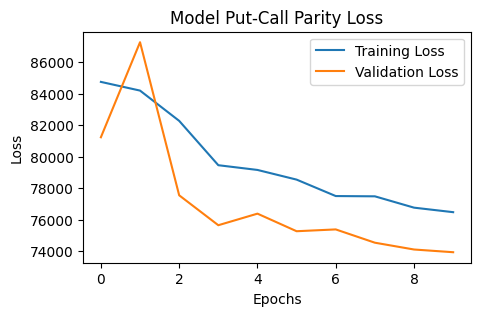

In [297]:
plt.figure(figsize=(5, 3))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Model Put-Call Parity Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Comparing with the results from the previous models

In [298]:
X = df2[['strike_rescaled', 'days_to_expiry', 'spread_relatif']][df2['option_type'] == 'call']
y = df2['mid_option'][df2['option_type'] == 'call']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MSE: 7368.3646
MAE: 59.4321
RMSE: 85.83918
MAPE: 839.95098 %
R2: 0.05225
Max Error: 733.4892
Percentage of predictions within the spread: 0.96%


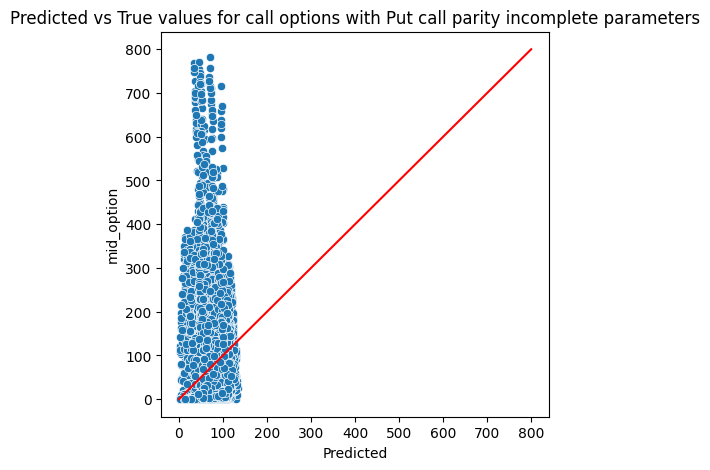

In [299]:
y_test_call = model.predict(X_test)[:, 0]
show_metrics(y_test, y_test_call)
show_graph(y_test_call, y_test, opt_type = "call", title="Put call parity incomplete parameters")
value = percentage_within_spread(y_test_call, y_test, df2)

The model did not provide a better result than the first model, given the complexity of the loss function and the low amount of input features.

Also, we can see that the model requires more epochs to converge and more training time because of the increased complexity of the model.

Lastly, we can see the effects of the put-call parity, since the prediction output is in a given range of values, but it seems that the loss due to the distance to the correct price of the call or put is not taken into account by the model.

### Put call parity first model, incomplete parameters + vol

In [301]:
from tensorflow.keras.optimizers import Adam

batch_size = 128
num_epochs = 10

# Define Early Stopping and Learning Rate Reduction parameters
patience = 10
patience_learning_rate = 5
lr_reduction_factor = 0.5
min_lr = 1e-6

# Early Stopping variables
best_val_loss = float('inf')
epochs_without_improvement = 0

current_lr = 1e-3
optimizer = Adam(learning_rate=current_lr)
model2 = create_put_call_model(use_bias=False, input_dim=4)

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)

training_loss = []
validation_loss = []

np.random.seed(44)
tf.random.set_seed(44)

df2['call_price'] = np.where(df2['option_type'] == 'call', df2['mid_option'], np.nan)
df2['put_price'] = np.where(df2['option_type'] == 'put', df2['mid_option'], np.nan)

X = df2[['Close', 'strike','strike_rescaled', 'days_to_expiry', 'spread_relatif', 'volatility', 'bs']]
y = df2[['call_price', 'put_price']]

X = X.dropna()
y = y.loc[X.index]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    epoch_loss = 0.0
    num_batches = 0
    
    # Iterate over the batches
    for X_batch, y_batch in dataset:
        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = model2(X_batch[:, 2:6], training=True)
            
            # Compute the loss
            loss = put_call_loss(y_batch, y_pred, X_batch)
        
        # Backpropagation
        gradients = tape.gradient(loss, model2.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model2.trainable_variables))
        
        # Accumulate the loss over all batches
        epoch_loss += loss.numpy()
        num_batches += 1
    
    # Compute the average training loss for the epoch
    average_loss = epoch_loss / num_batches
    print(f"Training Loss: {average_loss:.4f}")
    training_loss.append(average_loss)
    
    # Validation loss
    val_loss = 0.0
    num_val_batches = 0
    for X_val_batch, y_val_batch in tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size):
        val_pred = model2(X_val_batch[:, 2:6], training=False)
        val_loss += put_call_loss(y_val_batch, val_pred, X_val_batch).numpy()
        num_val_batches += 1
    val_loss /= num_val_batches
    print(f"Validation Loss: {val_loss:.4f}")
    validation_loss.append(val_loss)
    
    # Early Stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset patience counter
        print("Validation loss improved, saving model...")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epochs")
    
    if epochs_without_improvement >= patience:
        print("Early stopping triggered!")
        break
    
    # Learning Rate Reduction
    if epochs_without_improvement > 0 and epochs_without_improvement % patience_learning_rate == 0:
        current_lr = max(current_lr * lr_reduction_factor, min_lr)
        optimizer.learning_rate.assign(current_lr)
        print(f"Reducing learning rate to {current_lr:.6f}")
    

Epoch 1/10
Training Loss: 93847.7422
Validation Loss: 88598.9062
Validation loss improved, saving model...
Epoch 2/10
Training Loss: 86600.7031
Validation Loss: 81807.9844
Validation loss improved, saving model...
Epoch 3/10
Training Loss: 83611.4609
Validation Loss: 78803.9297
Validation loss improved, saving model...
Epoch 4/10
Training Loss: 79451.6094
Validation Loss: 75461.4297
Validation loss improved, saving model...
Epoch 5/10
Training Loss: 77625.6797
Validation Loss: 74594.2344
Validation loss improved, saving model...
Epoch 6/10
Training Loss: 77363.1719
Validation Loss: 74577.0781
Validation loss improved, saving model...
Epoch 7/10
Training Loss: 76912.3984
Validation Loss: 74039.6953
Validation loss improved, saving model...
Epoch 8/10
Training Loss: 76668.5391
Validation Loss: 73658.2266
Validation loss improved, saving model...
Epoch 9/10
Training Loss: 76667.8438
Validation Loss: 73711.5625
No improvement for 1 epochs
Epoch 10/10
Training Loss: 76075.7266
Validation Lo

In [302]:
X = df2[['strike_rescaled', 'days_to_expiry', 'spread_relatif', 'volatility']][df2['option_type'] == 'call']
y = df2['mid_option'][df2['option_type'] == 'call']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MSE: 7538.97224
MAE: 62.53686
RMSE: 86.82726
MAPE: 1085.75935 %
R2: 0.0303
Max Error: 724.0962
Percentage of predictions within the spread: 0.94%


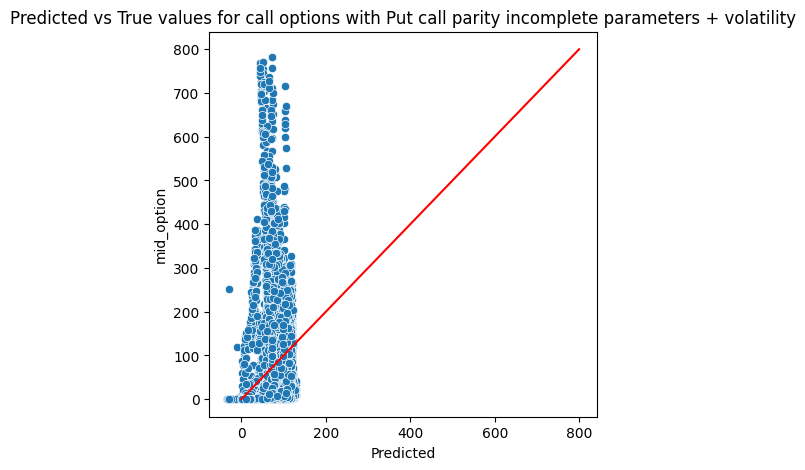

In [303]:
y_test_call = model2.predict(X_test)[:, 0]
show_metrics(y_test, y_test_call)
show_graph(y_test_call, y_test, opt_type = "call", title="Put call parity incomplete parameters + volatility")
value = percentage_within_spread(y_test_call, y_test, df2)

In here we have a very similar result to the previous model. The volatility is not helping the model to converge. We can see the effects of the put-call parity but not the mean square error.

### Put call parity first model, incomplete parameters + vol + black scholes

In [305]:
from tensorflow.keras.optimizers import Adam

batch_size = 128
num_epochs = 10

# Define Early Stopping and Learning Rate Reduction parameters
patience = 10
patience_learning_rate = 5
lr_reduction_factor = 0.5
min_lr = 1e-6

# Early Stopping variables
best_val_loss = float('inf')
epochs_without_improvement = 0

current_lr = 1e-3
optimizer = Adam(learning_rate=current_lr)
model3 = create_put_call_model(use_bias=False, input_dim=5)

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)

training_loss = []
validation_loss = []

np.random.seed(44)
tf.random.set_seed(44)

df2['call_price'] = np.where(df2['option_type'] == 'call', df2['mid_option'], np.nan)
df2['put_price'] = np.where(df2['option_type'] == 'put', df2['mid_option'], np.nan)

X = df2[['Close', 'strike','strike_rescaled', 'days_to_expiry', 'spread_relatif', 'volatility', 'bs']]
y = df2[['call_price', 'put_price']]

X = X.dropna()
y = y.loc[X.index]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    epoch_loss = 0.0
    num_batches = 0
    
    # Iterate over the batches
    for X_batch, y_batch in dataset:
        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = model3(X_batch[:, 2:7], training=True)
            
            # Compute the loss
            loss = put_call_loss(y_batch, y_pred, X_batch)
        
        # Backpropagation
        gradients = tape.gradient(loss, model3.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model3.trainable_variables))
        
        # Accumulate the loss over all batches
        epoch_loss += loss.numpy()
        num_batches += 1
    
    # Compute the average training loss for the epoch
    average_loss = epoch_loss / num_batches
    print(f"Training Loss: {average_loss:.4f}")
    training_loss.append(average_loss)
    
    # Validation loss
    val_loss = 0.0
    num_val_batches = 0
    for X_val_batch, y_val_batch in tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size):
        val_pred = model3(X_val_batch[:, 2:7], training=False)
        val_loss += put_call_loss(y_val_batch, val_pred, X_val_batch).numpy()
        num_val_batches += 1
    val_loss /= num_val_batches
    print(f"Validation Loss: {val_loss:.4f}")
    validation_loss.append(val_loss)
    
    # Early Stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset patience counter
        print("Validation loss improved, saving model...")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epochs")
    
    if epochs_without_improvement >= patience:
        print("Early stopping triggered!")
        break
    
    # Learning Rate Reduction
    if epochs_without_improvement > 0 and epochs_without_improvement % patience_learning_rate == 0:
        current_lr = max(current_lr * lr_reduction_factor, min_lr)
        optimizer.learning_rate.assign(current_lr)
        print(f"Reducing learning rate to {current_lr:.6f}")
    

Epoch 1/10
Training Loss: 53344.2695
Validation Loss: 49007.7656
Validation loss improved, saving model...
Epoch 2/10
Training Loss: 49177.3164
Validation Loss: 48663.6484
Validation loss improved, saving model...
Epoch 3/10
Training Loss: 47257.0820
Validation Loss: 44795.5820
Validation loss improved, saving model...
Epoch 4/10
Training Loss: 45750.8047
Validation Loss: 46725.3633
No improvement for 1 epochs
Epoch 5/10
Training Loss: 44903.4805
Validation Loss: 41955.1602
Validation loss improved, saving model...
Epoch 6/10
Training Loss: 43897.2031
Validation Loss: 43069.2188
No improvement for 1 epochs
Epoch 7/10
Training Loss: 43690.1914
Validation Loss: 40560.7305
Validation loss improved, saving model...
Epoch 8/10
Training Loss: 42313.9102
Validation Loss: 40219.2188
Validation loss improved, saving model...
Epoch 9/10
Training Loss: 43135.6602
Validation Loss: 41142.3242
No improvement for 1 epochs
Epoch 10/10
Training Loss: 42115.5273
Validation Loss: 39602.3398
Validation lo

659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step
MSE: 904.14014
MAE: 12.30873
RMSE: 30.06892
MAPE: 844.41086 %
R2: 0.88371
Max Error: 364.9202
Percentage of predictions within the spread: 10.85%


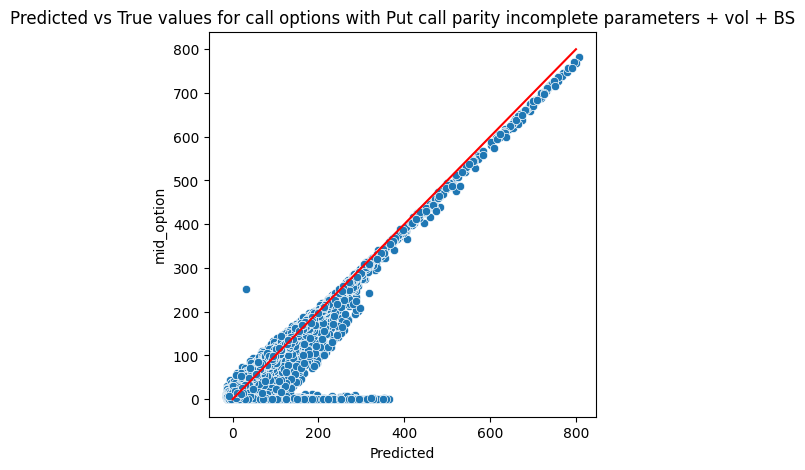

In [306]:
X = df2[['strike_rescaled', 'days_to_expiry', 'spread_relatif', 'volatility', 'bs']][df2['option_type'] == 'call']
y = df2['mid_option'][df2['option_type'] == 'call']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

y_test_call = model3.predict(X_test)[:, 0]
show_metrics(y_test, y_test_call)
show_graph(y_test_call, y_test, opt_type = "call", title="Put call parity incomplete parameters + vol + BS")
value = percentage_within_spread(y_test_call, y_test, df2)

This model didn't improve the results from the other section, but it is way better than the two models of the put call parity. We can observe that the model is converging, but the predictions for low mid-option values have a higher error. This might be due to the loss function of the put-call parity. 